# Newton's Method for Logistic Regression
I am going to use Newton's Method as optimization technique to perform Maximum Likelihood Estimation

### Our task
We're going to compute the probability that someone has Diabetes given their height, weight, and blood pressure. 
We'll generate this data ourselves (toy data), plot it, learn a logistic regression curve using Newton's Method 
for Optimization, then use that curve to predict the probability someone new with these 3 features has diabetes. 

### Why use Newton's Method for optimizing?
- Newton’s method usually converges faster than gradient descent when maximizing logistic regression log likelihood.
- Each iteration is more expensive than gradient descent because of calculating inverse of Hessian
- As long as data points are not very large, Newton’s methods are preferred

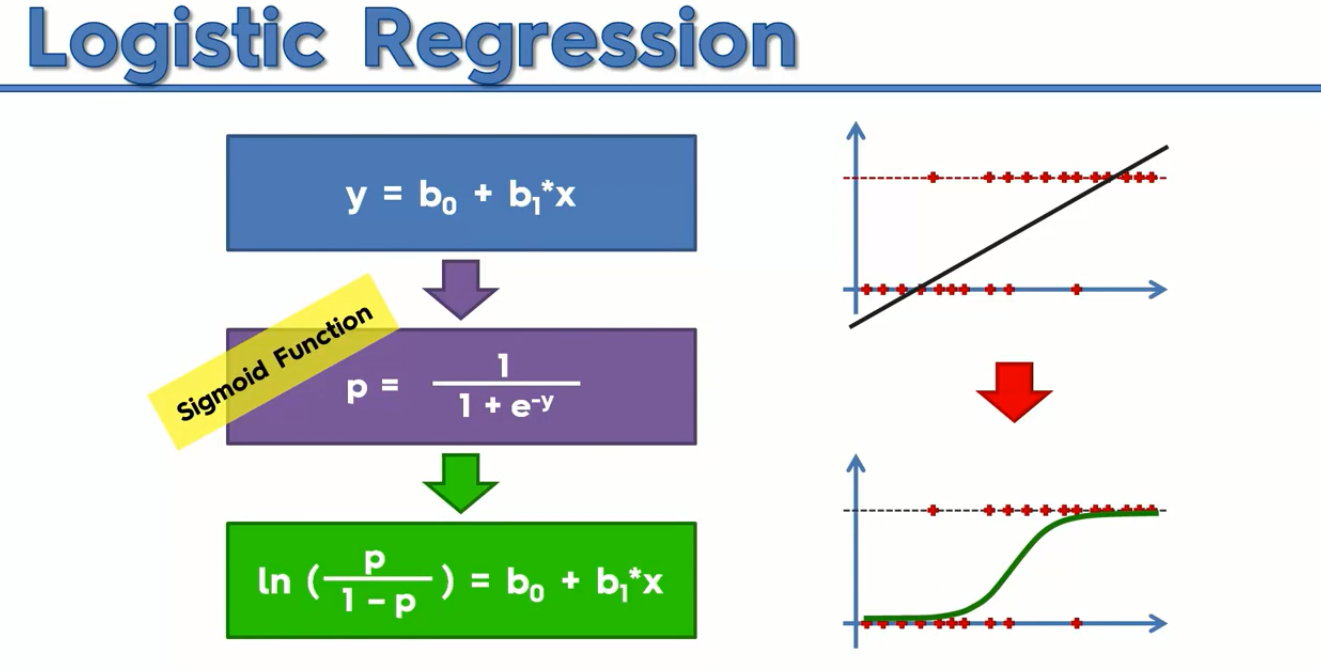

In [1]:
%matplotlib inline

#matrix math
import numpy as np
#data manipulation
import pandas as pd
#matrix data structure
from patsy import dmatrices
#for error logging
import warnings

In [2]:
#outputs probability between 0 and 1
def sigmoid(x):
    '''Sigmoid function of x.'''
    return 1/(1+np.exp(-x))

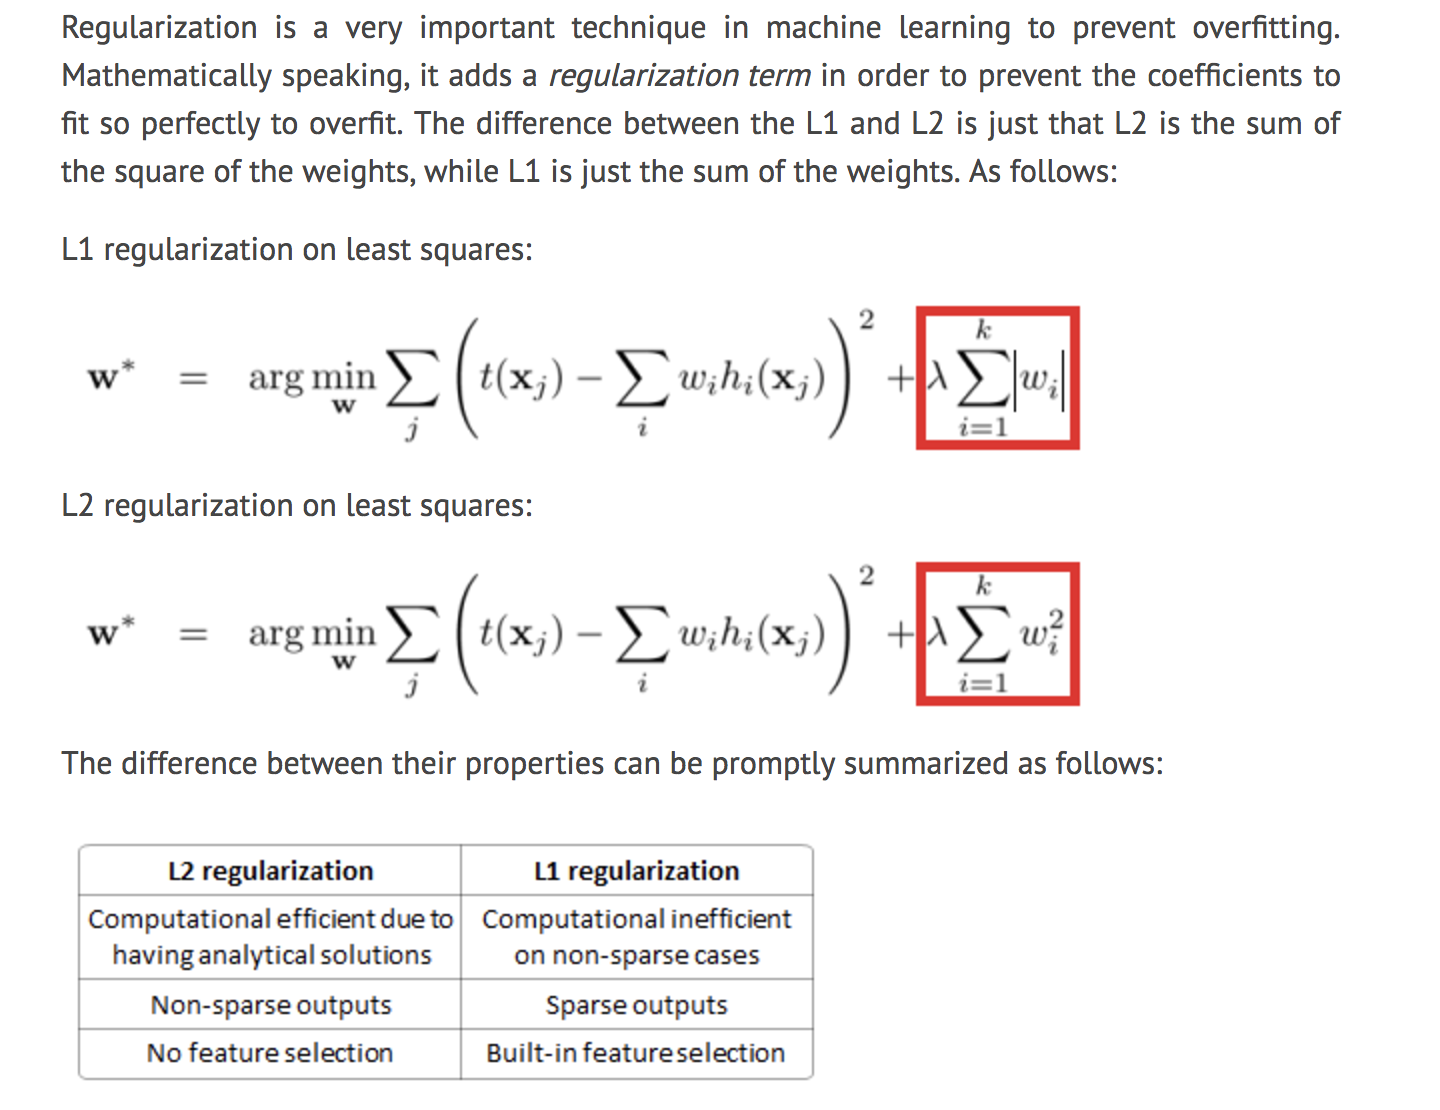

In [3]:
#makes the random numbers predictable
#(pseudo-)random numbers work by starting with a number (the seed), 
#multiplying it by a large number, then taking modulo of that product. 
#The resulting number is then used as the seed to generate the next "random" number. 
#When you set the seed (every time), it does the same thing every time, giving you the same numbers.
#good for reproducing results for debugging


np.random.seed(0) # set the seed

##Step 1 - Define model parameters (hyperparameters)

## algorithm settings
#the minimum threshold for the difference between the predicted output and the actual output
#this tells our model when to stop learning, when our prediction capability is good enough
tol=1e-8 # convergence tolerance

lam = None # l2-regularization
#how long to train for?
max_iter = 20 # maximum allowed iterations

## data creation settings
#Covariance measures how two variables move together. 
#It measures whether the two move in the same direction (a positive covariance) 
#or in opposite directions (a negative covariance). 
r = 0.95 # covariance between x and z
n = 1000 # number of observations (size of dataset to generate) 
sigma = 1 # variance of noise - how spread out is the data?

## model settings
beta_x, beta_z, beta_v = -4, .9, 1 # true beta coefficients
var_x, var_z, var_v = 1, 1, 4 # variances of inputs

## the model specification you want to fit
formula = 'y ~ x + z + v + np.exp(x) + I(v**2 + z)'

In [5]:
## Step 2 - Generate and organize our data

#The multivariate normal, multinormal or Gaussian distribution is a generalization of the one-dimensional normal 
#distribution to higher dimensions. Such a distribution is specified by its mean and covariance matrix.
#so we generate values input values - (x, v, z) using normal distributions

#A probability distribution is a function that provides us the probabilities of all 
#possible outcomes of a stochastic process. 

#lets keep x and z closely related (height and weight)
x, z = np.random.multivariate_normal([0,0], [[var_x,r],[r,var_z]], n).T
#blood presure
v = np.random.normal(0,var_v,n)**3

#create a pandas dataframe (easily parseable object for manipulation)
A = pd.DataFrame({'x' : x, 'z' : z, 'v' : v})
#compute the log odds for our 3 independent variables
#using the sigmoid function 
A['log_odds'] = sigmoid(A[['x','z','v']].dot([beta_x,beta_z,beta_v]) + sigma*np.random.normal(0,1,n))



#compute the probability sample from binomial distribution
#A binomial random variable is the number of successes x has in n repeated trials of a binomial experiment. 
#The probability distribution of a binomial random variable is called a binomial distribution. 
A['y'] = [np.random.binomial(1,p) for p in A.log_odds]

#create a dataframe that encompasses our input data, model formula, and outputs
y, X = dmatrices(formula, A, return_type='dataframe')

#print it
X.head(10)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


,Intercept,x,z,v,np.exp(x),I(v ** 2 + z)
0,1.0,-1.611418,-1.566192,15.613483,0.199604,242.214667
1,1.0,-0.080909,0.085959,42.720111,0.922278,1825.093814
2,1.0,0.297531,0.142110,3.530885,1.346531,12.609259
3,1.0,1.412771,1.734809,-57.235945,4.107323,3277.688187
4,1.0,0.204214,-0.302335,-0.074792,1.226561,-0.296741
5,1.0,1.515413,2.075660,-74.190590,4.551301,5506.319245
6,1.0,-1.122694,-1.001452,-115.449743,0.325402,13327.641761
7,1.0,1.490410,1.406678,203.717128,4.438913,41502.075078
8,1.0,1.076719,0.961474,18.996406,2.935033,361.824934
9,1.0,0.328823,0.099469,0.001091,1.389332,0.099470


##### Algorithm Setup
We begin with a quick function for catching singular matrix errors that we will use to decorate our Newton steps.

In [6]:
#like dividing by zero (Wtff omgggggg universe collapses)
def catch_singularity(f):
    '''Silences LinAlg Errors and throws a warning instead.'''
    
    def silencer(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except np.linalg.LinAlgError:
            warnings.warn('Algorithm terminated - singular Hessian!')
            return args[0]
    return silencer

#### Explanation of a Single Newton Step
Recall that Newton's method for maximizing / minimizing a given function $f(\beta)$ iteratively computes the following estimate:

$$
\beta^+ = \beta - Hf(\beta)^{-1}\nabla f(\beta)
$$
The Hessian of the log-likelihood for logistic regression is given by:

hessian of our function = negative tranpose of (N times (p+1) times (N x N diagional matrix of weights, each is p*(1-p) times X again

$$
Hf(\beta) = -X^TWX
$$
and the gradient is:

gradient of our function = tranpose of X times (column vector - N vector of probabilities)

$$
\nabla f(\beta) = X^T(y-p)
$$
where $$
W := \text{diag}\left(p(1-p)\right)
$$ and $p$ are the predicted probabilites computed at the current value of $\beta$.

#### Connection to Iteratively Reweighted Least Squares (IRLS)
For logistic regression, this step is actually equivalent to computing a weighted least squares estimator at each iteration! The method of least squares is about estimating parameters by minimizing the squared discrepancies between observed data, on the one hand, and their expected values on the other

I.e., $$
\beta^+ = \arg\min_\beta (z-X\beta)^TW(z-X\beta)
$$ with $W$ as before and the adjusted response $z$ is given by $$
z := X\beta + W^{-1}(y-p)
$$

Takeaway: This is fun, but in fact it can be leveraged to derive asymptotics and inferential statistics about the computed MLE $\beta^*$!

##### Our implementations
Below we implement a single step of Newton's method, and we compute $Hf(\beta)^{-1}\nabla f(\beta)$ using np.linalg.lstsq(A,b) to solve the equation $Ax = b$. Note that this does not require us to compute the actual inverse of the Hessian.

In [7]:
@catch_singularity
def newton_step(curr, X, lam=None):
    '''One naive step of Newton's Method'''
    
    #how to compute inverse? http://www.mathwarehouse.com/algebra/matrix/images/square-matrix/inverse-matrix.gif
    
    ## compute necessary objects
    #create probability matrix, miniminum 2 dimensions, tranpose (flip it)
    p = np.array(sigmoid(X.dot(curr[:,0])), ndmin=2).T
    #create weight matrix from it
    W = np.diag((p*(1-p))[:,0])
    #derive the hessian 
    hessian = X.T.dot(W).dot(X)
    #derive the gradient
    grad = X.T.dot(y-p)
    
    ## regularization step (avoiding overfitting)
    if lam:
        # Return the least-squares solution to a linear matrix equation
        step, *_ = np.linalg.lstsq(hessian + lam*np.eye(curr.shape[0]), grad)
    else:
        step, *_ = np.linalg.lstsq(hessian, grad)
        
    ## update our 
    beta = curr + step
    
    return beta

Next, we implement Newton's method in a slightly different way; this time, at each iteration, we actually compute the full inverse of the Hessian using np.linalg.inv().

In [8]:
@catch_singularity
def alt_newton_step(curr, X, lam=None):
    '''One naive step of Newton's Method'''
    
    ## compute necessary objects
    p = np.array(sigmoid(X.dot(curr[:,0])), ndmin=2).T
    W = np.diag((p*(1-p))[:,0])
    hessian = X.T.dot(W).dot(X)
    grad = X.T.dot(y-p)
    
    ## regularization
    if lam:
        #Compute the inverse of a matrix.
        step = np.dot(np.linalg.inv(hessian + lam*np.eye(curr.shape[0])), grad)
    else:
        step = np.dot(np.linalg.inv(hessian), grad)
        
    ## update our weights
    beta = curr + step
    
    return beta

#### Convergence Setup
First we implement coefficient convergence; this stopping criterion results in convergence whenever $$
\|\beta^+ - \beta\|_\infty &lt; \epsilon
$$ where $\epsilon$ is a given tolerance.

In [9]:
def check_coefs_convergence(beta_old, beta_new, tol, iters):
    '''Checks whether the coefficients have converged in the l-infinity norm.
    Returns True if they have converged, False otherwise.'''
    #calculate the change in the coefficients
    coef_change = np.abs(beta_old - beta_new)
    
    #if change hasn't reached the threshold and we have more iterations to go, keep training
    return not (np.any(coef_change>tol) & (iters < max_iter))

## Numerical Examples
#### Standard Newton with Coefficient Convergence

In [10]:
## initial conditions
#initial coefficients (weight values), 2 copies, we'll update one
beta_old, beta = np.ones((len(X.columns),1)), np.zeros((len(X.columns),1))

#num iterations we've done so far
iter_count = 0
#have we reached convergence?
coefs_converged = False

#if we haven't reached convergence... (training step)
while not coefs_converged:
    
    #set the old coefficients to our current
    beta_old = beta
    #perform a single step of newton's optimization on our data, set our updated beta values
    beta = newton_step(beta, X, lam=lam)
    #increment the number of iterations
    iter_count += 1
    
    #check for convergence between our old and new beta values
    coefs_converged = check_coefs_convergence(beta_old, beta, tol, iter_count)
    
print('Iterations : {}'.format(iter_count))
print('Beta : {}'.format(beta))

Iterations : 19
Beta : [[-5.52054923e+29]
 [ 3.99522325e+29]
 [-5.64687199e+29]
 [ 7.84204654e+29]
 [-1.16296996e+28]
 [ 8.05959278e+29]]


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
